# Matrix Formalism

In this example we will consider the matrix formalism approach for a geometry of cylinders.

In [1]:
using SpinDoctor
using LinearAlgebra

if haskey(ENV, "GITHUB_ACTIONS")
    using CairoMakie
else
    using GLMakie
end

setup = CylinderSetup(;
    name = "Slice",
    ncell = 3,
    rmin = 2.0,
    rmax = 6.0,
    dmin = 0.2,
    dmax = 0.3,
    height = 1.0,
    bend = 0.0,
    twist = 0.0,
    ecs_shape = :convex_hull,
    ecs_ratio = 0.5,
)

CylinderSetup{Float64}("Slice", "meshfiles", 3, 2.0, 6.0, 0.2, 0.3, 1.0, 0.0, 0.0, false, 0.5, :convex_hull, 0.5, Inf)

We also define coefficients for the different cell compartments `:in` (axon), `:out`
(myelin), and `:ecs` (ECS).

In [2]:
coeffs = coefficients(
    setup;
    D = (; in = 0.002 * I(3), out = 0.002 * I(3), ecs = 0.002 * I(3)),
    T₂ = (; in = Inf, out = Inf, ecs = Inf),
    ρ = (; in = 1.0, out = 1.0, ecs = 1.0),
    κ = (; in_out = 1e-4, out_ecs = 1e-4, in = 0.0, out = 0.0, ecs = 0.0),
    γ = 2.67513e-4,
)

(D = StaticArrays.SMatrix{3, 3, Float64, 9}[[0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002], [0.002 0.0 0.0; 0.0 0.002 0.0; 0.0 0.0 0.002]], T₂ = [Inf, Inf, Inf, Inf], κ = [0.0001, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0], ρ = ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im], γ = 0.000267513)

We then proceed to build the geometry and finite element mesh.

[ Info: Writing cell geometry to meshfiles/Slice_cells
[ Info: Saving mesh in Tetgen output format at meshfiles/Slice_dir/Slice_mesh.1


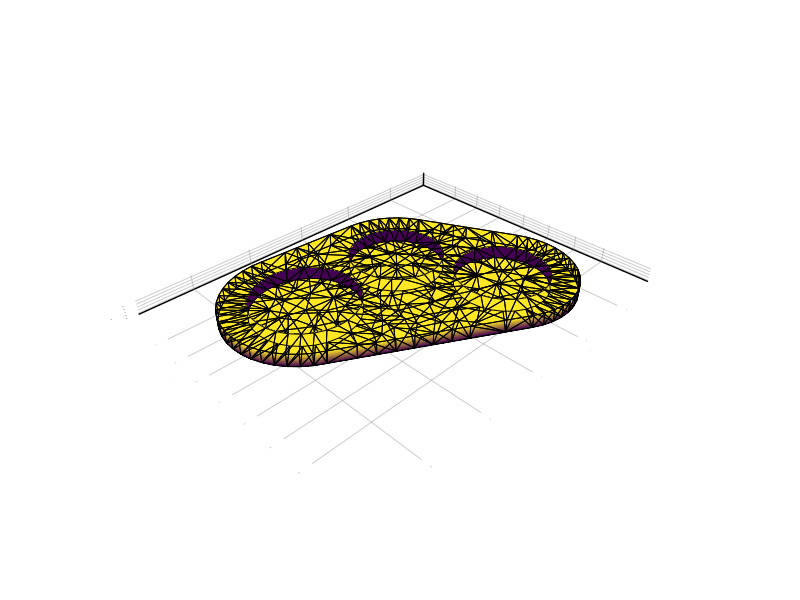

In [3]:
mesh, = create_geometry(setup; recreate = true)
plot_mesh(mesh)

The mesh looks good, so we may then proceed to assemble the biological model and the
associated finite element matrices.

In [4]:
model = Model(; mesh, coeffs...);
matrices = assemble_matrices(model);

We may also compute some useful quantities, including a scalar diffusion coefficient from
the diffusion tensors.

In [5]:
volumes = get_cmpt_volumes(model.mesh)
D_avg = 1 / 3 * tr.(model.D)' * volumes / sum(volumes)

0.002

The eigenfunctions of the diffusive part of the Bloch-Torrey operator forms a good basis
for the finite element function space. The basis may be truncated at a certain level, thus
reducing the number of degrees of freedom. We here opt for 400 eigenfunctions.

In [6]:
laplace = Laplace(; model, matrices, neig_max = 400)
lap_eig = solve(laplace)

┌ Info: Solving Laplace eigenvalue problem, computing 400 eigenvalues.
└ Problem size: 576 points.


(values = [1.3520124205965646e-17, 1.942562683493619e-5, 3.65498561118288e-5, 6.73520029485366e-5, 8.558157762551477e-5, 9.416490981941154e-5, 0.00011834337862498982, 0.00013143831994963962, 0.00021787552257236797, 0.00023335997306184094  …  0.052865405129943165, 0.05338634311200098, 0.05359780310423176, 0.05423491273935501, 0.054465423474658214, 0.05471830891737075, 0.05483115354072998, 0.05486334152566705, 0.05501047913385381, 0.05511105259393516], funcs = [0.056594507508744396 0.08450711721047827 … -0.00041149826718014676 -0.005828879488487571; 0.05659450750874279 0.08385902168594246 … -1.117259736745571e-5 0.001099984662802905; … ; 0.05659450750875107 -0.03514282148874158 … 0.004225926941815797 -0.040537259834312805; 0.05659450750875241 -0.03155247489379664 … 0.0038792456856700888 0.052767264480293105], moments = [[-0.4798206379073504 5.399702654951936 … -0.0016472924537602376 -0.00014725682248033396; 5.399702654951934 0.005883939945755978 … 0.002218302174304339 8.518501164608144e-

The resulting eigenvalues may be represented as length scales, describing the wavelength
of the eigenfunctions.

In [7]:
length_scales = eig2length.(lap_eig.values, D_avg)

400-element Vector{Float64}:
  3.8209779355442025e7
 31.876993191018695
 23.23924608146352
 17.119442307966455
 15.187095590423445
 14.478391740452198
 12.914954740445003
 12.254733490433818
  9.518327631900503
  9.197116495809157
  ⋮
  0.6080646885609383
  0.6068640010232614
  0.6032889873943573
  0.6020110019306886
  0.6006182676996682
  0.599999901630062
  0.5998238676813135
  0.5990211502252983
  0.5984743167143289

We may also further truncate the eigenfunction basis, if we are satisfied skipping
features below a threshold length scale of 3 micrometers.

In [8]:
length_scale = 3
λ_max = length2eig(length_scale, D_avg)
lap_eig = limit_lengthscale(lap_eig, λ_max)

(values = [1.3520124205965646e-17, 1.942562683493619e-5, 3.65498561118288e-5, 6.73520029485366e-5, 8.558157762551477e-5, 9.416490981941154e-5, 0.00011834337862498982, 0.00013143831994963962, 0.00021787552257236797, 0.00023335997306184094  …  0.00142942898683142, 0.0015351825500067944, 0.0016249468859682193, 0.0017143123284347145, 0.0017192407375525062, 0.0017678850538639674, 0.0017809593696614418, 0.0018557460290788887, 0.0019680580415198747, 0.002083897128379902], funcs = [0.056594507508744396 0.08450711721047827 … 0.009473881437531834 -0.009516073486481086; 0.05659450750874279 0.08385902168594246 … 0.004318197417206344 0.0010820940549670127; … ; 0.05659450750875107 -0.03514282148874158 … -0.1158920897079315 -0.0567095228722405; 0.05659450750875241 -0.03155247489379664 … -0.05239496900119858 -0.03133530102361013], moments = [[-0.4798206379073504 5.399702654951936 … 0.0202721957688269 -0.008478045325306457; 5.399702654951934 0.005883939945755978 … -0.055985122604510676 0.01213240293153

Each of the resulting eigenfunctions is represented in the same way as the initial
magnetization field `ρ`.

┌ Warning: Assignment to `nboundary` in soft scope is ambiguous because a global variable by the same name exists: `nboundary` will be treated as a new local. Disambiguate by using `local nboundary` to suppress this warning or `global nboundary` to assign to the existing global variable.
└ @ string:7


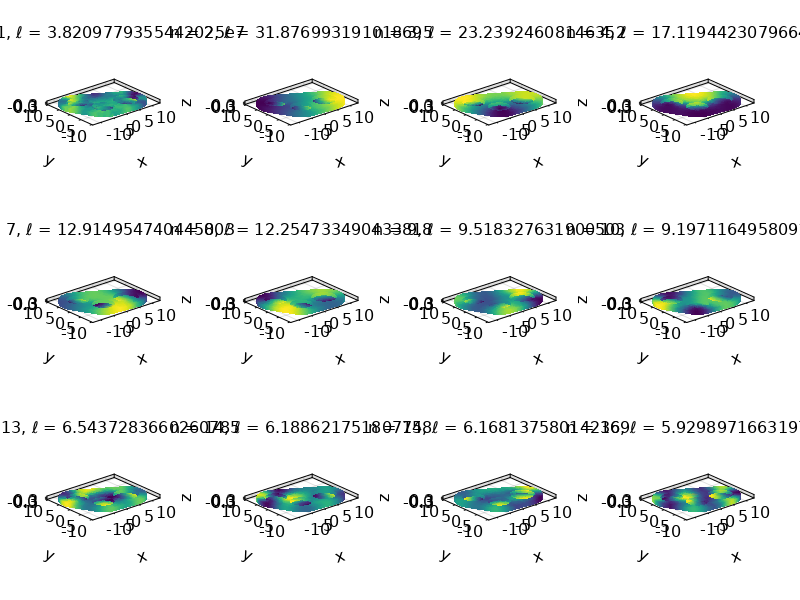

In [9]:
ncompartment, nboundary = size(mesh.facets)
fig = Figure()
for i = 1:3, j = 1:4
    ieig = 6(i - 1) + j
    ϕ_cmpts = split_field(mesh, lap_eig.funcs[:, ieig])
    ax = Axis3(fig[i, j]; title = "n = $ieig, ℓ = $(length_scales[ieig])", aspect = :data)
    nboundary = size(mesh.facets, 2)
    scene = nothing
    first = true
    for icmpt = 1:ncompartment, iboundary = 1:nboundary
        facets = mesh.facets[icmpt, iboundary]
        points = mesh.points[icmpt]
        mesh!(ax, points', facets', color = ϕ_cmpts[icmpt], shading = false)
    end
end
fig

We observe that the first functions have large features, while the higher-index functions
have more rapidly varying features. We may now choose a gradient and compute the
projection of magnetization field onto the truncated basis.

In [10]:
dir = [1.0, 0.0, 0.0]
profile = CosOGSE(5000.0, 5000.0, 2)
b = 1000
g = √(b / int_F²(profile)) / coeffs.γ
gradient = ScalarGradient(dir, profile, g)

The matrix formalism problem is solved in the same way as the `BTPDE`. The time
profile is approximated on 500 points, since it is non-constant.

In [11]:
mf = MatrixFormalism(; model, matrices, lap_eig)
ξ = solve(mf, gradient; ninterval = 500)

576-element Vector{ComplexF64}:
 0.25336575713814913 + 0.04597837773460361im
  0.2502315064509134 + 0.043968293280488534im
 0.24311009325236713 + 0.04079179391424062im
 0.23286921560318238 + 0.03657003685103212im
 0.22105003021359132 + 0.03154368224193233im
 0.21039314454604915 + 0.02516888516534856im
  0.2010815608141075 + 0.019506203732627212im
 0.19502212048008222 + 0.013537953151369743im
 0.19480879447956836 + 0.008837286949263556im
  0.1973962487163326 + 0.004618211438245936im
                     ⋮
 0.31055276701756107 + 0.010610996453981576im
  0.3703767128881035 - 0.04555018937434624im
  0.3698210875284907 - 0.04531190732553775im
  0.2982502981081611 + 0.020113476138728208im
 0.35831959844083866 - 0.032286275138335284im
   0.357683647962413 - 0.033389175972718566im
  0.3605829597401563 - 0.03989009191608178im
 0.36187885769992506 - 0.04492424246361009im
   0.359985738751125 - 0.04616007763808702im

The resulting magnetization field may be plotted.

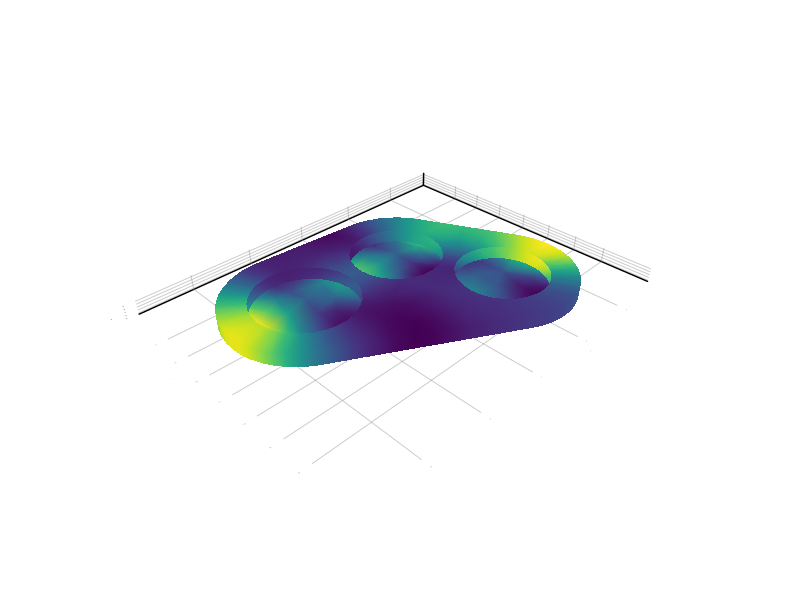

In [12]:
plot_field(model.mesh, ξ)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*